In [1]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 10.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import gdown
import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from scipy.spatial.distance import jaccard, dice, hamming
from scipy.stats import pearsonr, entropy
from sklearn.cluster import KMeans
from gensim.corpora import Dictionary
from gensim.similarities import WmdSimilarity
from gensim.models import KeyedVectors
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

url = "https://drive.google.com/file/d/1y9qBtV71aY6OtEnhfQAxMTWXBBmdv63i/view?usp=drive_link"
output = "dataset.csv"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1y9qBtV71aY6OtEnhfQAxMTWXBBmdv63i
To: /content/dataset.csv
100%|██████████| 93.0M/93.0M [00:01<00:00, 62.6MB/s]


'dataset.csv'

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# import dataset

In [4]:
dataset = pd.read_csv("dataset.csv")

In [5]:
pd.set_option("display.max_colwidth",None)

In [6]:
dataset.head()

id_pekerjaan  id_perusahaan                 skill  \
0    3690843087        6049228   Accounting/Auditing   
1    3691775263        2641066            Management   
2    3691786992       82684341  Health Care Provider   
3    3691789797       82296828            Management   
4    3691792844       86746333           Engineering   

                                                           job title  \
0                                       real estate staff accountant   
1                                             maintenance technician   
2                                                        optometrist   
3  commercial drivers license commercial truck driver immediate hire   
4                                         senior electrical engineer   

  jenis_pekerjaan   registration_type category sponsor       city  \
0       Full-time  ComplexOnsiteApply    not sponsored    norwood   
1       Full-time  ComplexOnsiteApply    not sponsored   westmont   
2       Part-time  ComplexOnsiteApply    not sponsored  milwaukee   
3       Temporary  ComplexOnsiteApply    not sponsored      elgin   
4       Full-time  ComplexOnsiteApply    not sponsored   old fort   

            state         county  \
0   massachusetts  united states   
1        illinois  united states   
2       wisconsin  united states   
3           texas  united states   
4  north carolina  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Modeling

In [85]:
input_text = "At the age of 28, I, John Smith, am an enthusiastic and highly skilled data analyst seeking to advance my career by applying for a position in the data field. With over five years of experience in data analysis and a proven track record of successfully implementing data-driven strategies, I have honed my expertise in various analytical tools and methodologies. I hold a Bachelor's degree in Computer Science from the University of California, Berkeley, and a Master's degree in Data Science from Stanford University. Throughout my career, I have demonstrated exceptional analytical capabilities, strong problem-solving skills, and a deep understanding of statistical models and machine learning algorithms. My passion for uncovering insights from complex datasets and my commitment to continuous learning make me a valuable candidate for any data-driven organization."

In [86]:
input_text = input_text.lower()
input_text = re.sub(r'[^\w\s]', '', input_text)
tokens = word_tokenize(input_text)
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(word) for word in tokens]
input_text = ' '.join(tokens)

In [87]:
corpus = dataset["deskripsi_keterampilan_final"].tolist() + [input_text]

In [88]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

In [89]:
cosine_similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])
dataset["cosine_similarity"] = cosine_similarities.flatten()

In [90]:
euclidean_dist = euclidean_distances(tfidf_matrix[-1], tfidf_matrix[:-1])
dataset["euclidean_distance"] = euclidean_dist.flatten()

In [91]:
manhattan_dist = manhattan_distances(tfidf_matrix[-1], tfidf_matrix[:-1])
dataset["manhattan_distance"] = manhattan_dist.flatten()

In [92]:
def jaccard_similarity(s1, s2):
    s1 = set(s1.split())
    s2 = set(s2.split())
    return len(s1 & s2) / len(s1 | s2)
dataset["jaccard_similarity"] = dataset["deskripsi_keterampilan_final"].apply(lambda x: jaccard_similarity(x, input_text))

In [93]:
def dice_coefficient(s1, s2):
    s1 = set(s1.split())
    s2 = set(s2.split())
    return 2 * len(s1 & s2) / (len(s1) + len(s2))
dataset["dice_coefficient"] = dataset["deskripsi_keterampilan_final"].apply(lambda x: dice_coefficient(x, input_text))

In [94]:
def pearson_corr(x, y):
    return pearsonr(x.toarray().flatten(), y.toarray().flatten())[0]
pearson_corrs = [pearson_corr(tfidf_matrix[i], tfidf_matrix[-1]) for i in range(len(corpus) - 1)]
dataset["pearson_correlation"] = pearson_corrs

In [16]:
model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [95]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text
def wmd_distance(s1, s2):
    s1 = clean_text(s1)
    s2 = clean_text(s2)

    s1_words = s1.split()
    s2_words = s2.split()

    s1_words = [word for word in s1_words if word in model]
    s2_words = [word for word in s2_words if word in model]

    if not s1_words or not s2_words:
        return float('inf')

    return model.wmdistance(s1_words, s2_words)
dataset["wmd_distance"] = dataset["deskripsi_keterampilan_final"].apply(lambda x: wmd_distance(x, input_text))

In [96]:
def bhattacharyya_distance(p, q):
    return -np.log(np.sum(np.sqrt(p * q)))
def bhattacharyya_distance_from_vector(x, y):
    p = x / np.sum(x)
    q = y / np.sum(y)
    return bhattacharyya_distance(p, q)
bhattacharyya_distances = [bhattacharyya_distance_from_vector(tfidf_matrix[i].toarray().flatten(), tfidf_matrix[-1].toarray().flatten()) for i in range(len(corpus) - 1)]
dataset["bhattacharyya_distance"] = bhattacharyya_distances

<ipython-input-96-d747bff218ee>:2: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.sum(np.sqrt(p * q)))


In [97]:
def kl_divergence_from_vector(p, q):
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return entropy(p, q)
kl_divergences = [kl_divergence_from_vector(tfidf_matrix[i].toarray().flatten(), tfidf_matrix[-1].toarray().flatten()) for i in range(len(corpus) - 1)]
dataset["kl_divergence"] = kl_divergences

In [98]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31556 entries, 0 to 31555
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_pekerjaan                  31556 non-null  int64  
 1   id_perusahaan                 31556 non-null  int64  
 2   skill                         31556 non-null  object 
 3   job title                     31556 non-null  object 
 4   jenis_pekerjaan               31556 non-null  object 
 5   registration_type             31556 non-null  object 
 6   category sponsor              31556 non-null  object 
 7   city                          31556 non-null  object 
 8   state                         31556 non-null  object 
 9   county                        31556 non-null  object 
 10  deskripsi_keterampilan_final  31556 non-null  object 
 11  cosine_similarity             31556 non-null  float64
 12  euclidean_distance            31556 non-null  float64
 13  m

# Hasil

In [99]:
top_similar = dataset.sort_values(by='cosine_similarity', ascending=False).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
18373    3757469023       16198010                   Sales   
19252    3757450438         871133  Information Technology   
1784     3693049684       18581793      Project Management   
5171     3693591031          45975                 Analyst   
30759    3757454354         871133  Information Technology   
1142     3693046569       10577525      Project Management   
25555    3756113091        6408728             Engineering   
8853     3697394881          26067             Engineering   
1885     3693050174         163414      Project Management   
25279    3757489682         624581  Information Technology   

                                             job title jenis_pekerjaan  \
18373  next generation data analyst site new york city       Full-time   
19252                                   data scientist       Full-time   
1784                                    senior manager       Full-time   
5171              senior assessment evaluation analyst       Full-time   
30759                           machine learn engineer       Full-time   
1142                             data scientist remote       Full-time   
25555                            director data science       Full-time   
8853          analytics data solution architect stream       Full-time   
1885                                   product manager       Full-time   
25279                              senior data analyst       Full-time   

        registration_type category sponsor                    city  \
18373  ComplexOnsiteApply    not sponsored                new york   
19252  ComplexOnsiteApply    not sponsored                new york   
1784   ComplexOnsiteApply        sponsored  san francisco bay area   
5171         OffsiteApply        sponsored               palo alto   
30759  ComplexOnsiteApply    not sponsored                new york   
1142   ComplexOnsiteApply    not sponsored                new york   
25555        OffsiteApply        sponsored                  queens   
8853         OffsiteApply    not sponsored              scottsdale   
1885         OffsiteApply    not sponsored                 No Info   
25279        OffsiteApply    not sponsored                   plano   

            state         county  \
18373    new york  united states   
19252    new york  united states   
1784   california  united states   
5171   california  united states   
30759    new york  united states   
1142     new york  united states   
25555    new york  united states   
8853      arizona  united states   
1885      No Info  united states   
25279       texas  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [100]:
top_similar['cosine_similarity']

18373    0.255812
19252    0.241991
1784     0.220682
5171     0.218449
30759    0.214619
1142     0.205005
25555    0.203654
8853     0.199543
1885     0.194436
25279    0.192532
Name: cosine_similarity, dtype: float64

In [101]:
top_similar = dataset.sort_values(by='euclidean_distance', ascending=True).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
18373    3757469023       16198010                   Sales   
19252    3757450438         871133  Information Technology   
1784     3693049684       18581793      Project Management   
5171     3693591031          45975                 Analyst   
30759    3757454354         871133  Information Technology   
1142     3693046569       10577525      Project Management   
25555    3756113091        6408728             Engineering   
8853     3697394881          26067             Engineering   
1885     3693050174         163414      Project Management   
25279    3757489682         624581  Information Technology   

                                             job title jenis_pekerjaan  \
18373  next generation data analyst site new york city       Full-time   
19252                                   data scientist       Full-time   
1784                                    senior manager       Full-time   
5171              senior assessment evaluation analyst       Full-time   
30759                           machine learn engineer       Full-time   
1142                             data scientist remote       Full-time   
25555                            director data science       Full-time   
8853          analytics data solution architect stream       Full-time   
1885                                   product manager       Full-time   
25279                              senior data analyst       Full-time   

        registration_type category sponsor                    city  \
18373  ComplexOnsiteApply    not sponsored                new york   
19252  ComplexOnsiteApply    not sponsored                new york   
1784   ComplexOnsiteApply        sponsored  san francisco bay area   
5171         OffsiteApply        sponsored               palo alto   
30759  ComplexOnsiteApply    not sponsored                new york   
1142   ComplexOnsiteApply    not sponsored                new york   
25555        OffsiteApply        sponsored                  queens   
8853         OffsiteApply    not sponsored              scottsdale   
1885         OffsiteApply    not sponsored                 No Info   
25279        OffsiteApply    not sponsored                   plano   

            state         county  \
18373    new york  united states   
19252    new york  united states   
1784   california  united states   
5171   california  united states   
30759    new york  united states   
1142     new york  united states   
25555    new york  united states   
8853      arizona  united states   
1885      No Info  united states   
25279       texas  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [102]:
top_similar['euclidean_distance']

18373    1.219991
19252    1.231267
1784     1.248453
5171     1.250241
30759    1.253301
1142     1.260948
25555    1.262019
8853     1.265272
1885     1.269302
25279    1.270802
Name: euclidean_distance, dtype: float64

In [103]:
top_similar = dataset.sort_values(by='manhattan_distance', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
10555,3699088610,4196994,Education,article teacher,Full-time,SimpleOnsiteApply,not sponsored,washington,district of columbia,united states,artist,0.000000,1.414214,7.705016,0.000000,0.000000,-0.000165,1.371905,inf,24.928609
13484,3694158424,96350264,Quality Assurance,linkedin test vacancy,Contract,OffsiteApply,not sponsored,kings park,new york,united states,testtesttesttesttesttesttesttesttesttesttesttesttesttest,0.000000,1.414214,7.705016,0.000000,0.000000,-0.000165,inf,inf,24.928609
9410,3699057694,82301960,Legal,paralegal,Full-time,SimpleOnsiteApply,not sponsored,downers grove,illinois,united states,paralegal,0.000000,1.414214,7.705016,0.000000,0.000000,-0.000165,1.348018,inf,24.928609
3805,3693070832,75156982,Human Resources,group facilitator,Other,SimpleOnsiteApply,not sponsored,denver,colorado,united states,facilitator,0.000000,1.414214,7.705016,0.000000,0.000000,-0.000165,1.357242,inf,24.928609
4196,3693075405,1512,Sales,inbound stock team member,Part-time,ComplexOnsiteApply,not sponsored,scotts valley,california,united states,name,0.000000,1.414214,7.705016,0.000000,0.000000,-0.000165,1.378572,inf,24.928609
7794,3694126099,1384029,Finance,loan officer,Full-time,SimpleOnsiteApply,not sponsored,No Info,california,united states,go getter,0.000000,1.414214,8.030879,0.000000,0.000000,-0.000218,1.338333,inf,24.306018
9664,3694142328,13186641,Management,new york 迪拜分公司总经理,Full-time,ComplexOnsiteApply,not sponsored,new york,new york,united states,负责 在纽约 在纽约,0.000000,1.414214,8.046657,0.000000,0.000000,-0.000221,inf,inf,24.292121
2826,3693058243,1068662,Legal,associate attorney,Full-time,SimpleOnsiteApply,not sponsored,troy,michigan,united states,year fault experience necessary,0.008899,1.407907,8.198111,0.028986,0.056338,0.008641,1.229115,3.204118,19.786906
1755,3693049516,56581630,Management,senior transportation planner,Full-time,OffsiteApply,not sponsored,seattle,washington,united states,new sidewalk program manager,0.000000,1.414214,8.284074,0.000000,0.000000,-0.000260,1.309096,inf,23.797363
29878,3756117095,756229,Accounting/Auditing,senior accountant,Full-time,OffsiteApply,not sponsored,roseville,california,united states,senior accountant year experience,0.010685,1.406638,8.295685,0.028986,0.056338,0.010412,1.244217,3.142246,19.188017


In [104]:
top_similar['manhattan_distance']

10555    7.705016
13484    7.705016
9410     7.705016
3805     7.705016
4196     7.705016
7794     8.030879
9664     8.046657
2826     8.198111
1755     8.284074
29878    8.295685
Name: manhattan_distance, dtype: float64

In [105]:
top_similar = dataset.sort_values(by='jaccard_similarity', ascending=False).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
22536,3755577654,2562128,Engineering,senior software scientist medical imaging,Full-time,ComplexOnsiteApply,not sponsored,buffalo grove,illinois,united states,qualification ph master degree computer science software engineering related field prefer exceptional candidate stem area highly encourage apply minimum year hand experience algorithm development primarily c ct medical imaging application deep understanding ct medical image modality proven expertise computer vision machine learning medical image processing strong software design unit test skill knowledge medical terminology biomedical engineering desirable strong publication intellectual property record relate ai medical imaging proficiency program c python additional relevant languages excellent debugging troubleshoot ability familiarity directx firmware game engine image reconstruction matrix inversion lut implementation gpu cpu multithreading experience nvidia object orient coding python familiarity software architectural design design pattern sdlc tcp ip xml schema simulation agile methodology,0.091258,1.348141,12.772271,0.152174,0.264151,0.090018,0.930919,1.744911,17.611063
9283,3699055896,51701268,Information Technology,tableau architect,Contract,ComplexOnsiteApply,sponsored,No Info,new jersey,united states,seek experienced senior business intelligence architect strong focus tableau expertise join dynamic team ideal candidate proven track record interpret functional need leading requirement gather session design complex business intelligence system provide valuable insight use tableau seasoned professional extensive experience data analysis dashboard design mentoring encourage apply responsibility interpret functional need translate effective business intelligence solution lead facilitate requirement gather session stakeholder document detailed requirement design architect complex business intelligence system align organizational goal develop impact ful tableau dashboard report use various data source aws sql etc utilize expertise data warehousing tool technique data stage etl tableau prep ensure data quality consistency demonstrate deep understanding data warehouse lifecycle data source etl multidimensional model data mart star schema report provide consulting leadership mentorship junior team member analyze data identify pattern trend insight drive business decision making requirement bachelor degree computer science information technology business related field minimum year overall professional experience building bi report solution extensive experience depth knowledge business intelligence tool architecture least year hand experience tableau design development strong expertise bi design complex system project proficiency design dashboard report use diverse data source include aws sql etc familiarity data warehouse tool technique data stage etl tableau prep thorough understanding data warehouse lifecycle data source etl multidimensional model report exceptional consulting leadership mentor ability,0.138009,1.313005,12.535152,0.144578,0.252632,0.136865,0.905640,1.610408,16.691035
12904,3701310859,490432,Engineering,financial planning consultant,Contract,ComplexOnsiteApply,not sponsored,wilmington,delaware,united states,fp consultant wilmington role job description seek highly skilled experienced financial planning analysis fp data architect expertise tool strong background banking financial domain key member team responsible design implementing maintain data architecture responsibility data architecture design collaborate cross functional team understand business requirement design robust data architecture cater financial planning analysis need organization data in

In [106]:
top_similar['jaccard_similarity']

22536    0.152174
9283     0.144578
12904    0.137931
17502    0.132184
24110    0.131313
24805    0.126761
2312     0.126506
13387    0.126087
3405     0.125581
19252    0.125000
Name: jaccard_similarity, dtype: float64

In [107]:
top_similar = dataset.sort_values(by='dice_coefficient', ascending=False).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
22536,3755577654,2562128,Engineering,senior software scientist medical imaging,Full-time,ComplexOnsiteApply,not sponsored,buffalo grove,illinois,united states,qualification ph master degree computer science software engineering related field prefer exceptional candidate stem area highly encourage apply minimum year hand experience algorithm development primarily c ct medical imaging application deep understanding ct medical image modality proven expertise computer vision machine learning medical image processing strong software design unit test skill knowledge medical terminology biomedical engineering desirable strong publication intellectual property record relate ai medical imaging proficiency program c python additional relevant languages excellent debugging troubleshoot ability familiarity directx firmware game engine image reconstruction matrix inversion lut implementation gpu cpu multithreading experience nvidia object orient coding python familiarity software architectural design design pattern sdlc tcp ip xml schema simulation agile methodology,0.091258,1.348141,12.772271,0.152174,0.264151,0.090018,0.930919,1.744911,17.611063
9283,3699055896,51701268,Information Technology,tableau architect,Contract,ComplexOnsiteApply,sponsored,No Info,new jersey,united states,seek experienced senior business intelligence architect strong focus tableau expertise join dynamic team ideal candidate proven track record interpret functional need leading requirement gather session design complex business intelligence system provide valuable insight use tableau seasoned professional extensive experience data analysis dashboard design mentoring encourage apply responsibility interpret functional need translate effective business intelligence solution lead facilitate requirement gather session stakeholder document detailed requirement design architect complex business intelligence system align organizational goal develop impact ful tableau dashboard report use various data source aws sql etc utilize expertise data warehousing tool technique data stage etl tableau prep ensure data quality consistency demonstrate deep understanding data warehouse lifecycle data source etl multidimensional model data mart star schema report provide consulting leadership mentorship junior team member analyze data identify pattern trend insight drive business decision making requirement bachelor degree computer science information technology business related field minimum year overall professional experience building bi report solution extensive experience depth knowledge business intelligence tool architecture least year hand experience tableau design development strong expertise bi design complex system project proficiency design dashboard report use diverse data source include aws sql etc familiarity data warehouse tool technique data stage etl tableau prep thorough understanding data warehouse lifecycle data source etl multidimensional model report exceptional consulting leadership mentor ability,0.138009,1.313005,12.535152,0.144578,0.252632,0.136865,0.905640,1.610408,16.691035
12904,3701310859,490432,Engineering,financial planning consultant,Contract,ComplexOnsiteApply,not sponsored,wilmington,delaware,united states,fp consultant wilmington role job description seek highly skilled experienced financial planning analysis fp data architect expertise tool strong background banking financial domain key member team responsible design implementing maintain data architecture responsibility data architecture design collaborate cross functional team understand business requirement design robust data architecture cater financial planning analysis need organization data in

In [108]:
top_similar['dice_coefficient']

22536    0.264151
9283     0.252632
12904    0.242424
17502    0.233503
24110    0.232143
24805    0.225000
2312     0.224599
13387    0.223938
3405     0.223140
19252    0.222222
Name: dice_coefficient, dtype: float64

In [109]:
top_similar = dataset.sort_values(by='pearson_correlation', ascending=False).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
18373    3757469023       16198010                   Sales   
19252    3757450438         871133  Information Technology   
1784     3693049684       18581793      Project Management   
5171     3693591031          45975                 Analyst   
30759    3757454354         871133  Information Technology   
1142     3693046569       10577525      Project Management   
25555    3756113091        6408728             Engineering   
8853     3697394881          26067             Engineering   
1885     3693050174         163414      Project Management   
25279    3757489682         624581  Information Technology   

                                             job title jenis_pekerjaan  \
18373  next generation data analyst site new york city       Full-time   
19252                                   data scientist       Full-time   
1784                                    senior manager       Full-time   
5171              senior assessment evaluation analyst       Full-time   
30759                           machine learn engineer       Full-time   
1142                             data scientist remote       Full-time   
25555                            director data science       Full-time   
8853          analytics data solution architect stream       Full-time   
1885                                   product manager       Full-time   
25279                              senior data analyst       Full-time   

        registration_type category sponsor                    city  \
18373  ComplexOnsiteApply    not sponsored                new york   
19252  ComplexOnsiteApply    not sponsored                new york   
1784   ComplexOnsiteApply        sponsored  san francisco bay area   
5171         OffsiteApply        sponsored               palo alto   
30759  ComplexOnsiteApply    not sponsored                new york   
1142   ComplexOnsiteApply    not sponsored                new york   
25555        OffsiteApply        sponsored                  queens   
8853         OffsiteApply    not sponsored              scottsdale   
1885         OffsiteApply    not sponsored                 No Info   
25279        OffsiteApply    not sponsored                   plano   

            state         county  \
18373    new york  united states   
19252    new york  united states   
1784   california  united states   
5171   california  united states   
30759    new york  united states   
1142     new york  united states   
25555    new york  united states   
8853      arizona  united states   
1885      No Info  united states   
25279       texas  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [110]:
top_similar['pearson_correlation']

18373    0.254528
19252    0.240760
1784     0.219332
5171     0.216751
30759    0.213606
1142     0.203496
25555    0.202149
8853     0.197928
1885     0.192968
25279    0.190684
Name: pearson_correlation, dtype: float64

In [111]:
filtered_dataset = dataset[dataset["wmd_distance"] != float('inf')]
top_similar = filtered_dataset.sort_values(by='wmd_distance', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
19252,3757450438,871133,Information Technology,data scientist,Full-time,ComplexOnsiteApply,not sponsored,new york,new york,united states,henderson harbor group premier executive search consult firm deep experience technology finance accounting tax search division recruit highly skilled professional direct hire basis service client primarily tri state area well nationally aafa npa network data scientist forefront data drive decision make process work closely cross functional team extract valuable insight data build predictive model provide actionable recommendation drive business forward key responsibilities collect pre process data various source ensure data quality accuracy explore analyze visualize data identify trend pattern insight develop machine learning model algorithm predictive prescriptive analytics collaborate domain expert stakeholder define business problem objective design experiment conduct statistical analysis test hypothesis validate model evaluate select appropriate tool framework library data analysis model create data drive report dashboard communicate finding recommendation stay date latest data science technique technology participate development data science strategy road maps contribute data related project mentor junior data scientist provide technical guidance maintain strong focus data privacy ethic compliance qualifications bachelor master degree quantitative field computer science statistic data science proven experience data scientist similar role proficiency data analysis visualization tool python r sql strong knowledge machine learning statistic data mining experience data manipulation modeling library e g panda sci kit learn tensor flow strong problem solving analytical skill excellent communication presentation skill ability work effectively collaborative team environment knowledge big data technology distribute computing plus industry specific experience may require base role e g healthcare finance e commerce etc,0.241991,1.231267,13.744372,0.125000,0.222222,0.240760,0.885772,1.385320,15.449700
18373,3757469023,16198010,Sales,next generation data analyst site new york city,Full-time,ComplexOnsiteApply,not sponsored,new york,new york,united states,seek talented forward think next generation data analyst join team next generation data analyst play crucial role shape future data analysis within organization primary responsibility collaborate closely leadership understand business need identify data driven insight stay abreast industry trend emerge technology best practice data analysis position require deep understanding data analysis excellent problem solve skill hand experience key responsibility collaboration leadership work closely leadership understand business objective provide data driven insight inform decision making process present analysis finding recommendation leadership clear concise manner facilitate data drive discussion strategic planning assist ceo identify key performance indicator kpis metric measure success business strategy contribute develop data driven strategy initiative enhance business performance competitiveness data visualization create visually appeal easy understand dashboard chart report communicate complex data insight stakeholder use data visualization tool present finding compelling impact ful manner clean pre process analyze large datasets extract valuable pattern trend insight build deploy machine learning model various application predictive analytics recommendation system anomaly detection utilize statistical method tool validate model ensure accuracy reliability data quality integrity ensure data accuracy completeness consistency implement quality check vali

In [112]:
top_similar['wmd_distance']

19252    0.885772
18373    0.904577
9283     0.905640
12904    0.909893
28867    0.913847
17502    0.915533
1784     0.924095
1885     0.926653
18214    0.927891
2312     0.928276
Name: wmd_distance, dtype: float64

In [113]:
top_similar = dataset.sort_values(by='bhattacharyya_distance', ascending=True).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
18373    3757469023       16198010                   Sales   
19252    3757450438         871133  Information Technology   
30759    3757454354         871133  Information Technology   
24110    3757461432         490432             Engineering   
1885     3693050174         163414      Project Management   
1784     3693049684       18581793      Project Management   
12904    3701310859         490432             Engineering   
1142     3693046569       10577525      Project Management   
8853     3697394881          26067             Engineering   
1144     3693046572        2944478                 Finance   

                                             job title jenis_pekerjaan  \
18373  next generation data analyst site new york city       Full-time   
19252                                   data scientist       Full-time   
30759                           machine learn engineer       Full-time   
24110                                   data scientist       Full-time   
1885                                   product manager       Full-time   
1784                                    senior manager       Full-time   
12904                    financial planning consultant        Contract   
1142                             data scientist remote       Full-time   
8853          analytics data solution architect stream       Full-time   
1144                                         economist       Full-time   

        registration_type category sponsor                    city  \
18373  ComplexOnsiteApply    not sponsored                new york   
19252  ComplexOnsiteApply    not sponsored                new york   
30759  ComplexOnsiteApply    not sponsored                new york   
24110  ComplexOnsiteApply    not sponsored                new york   
1885         OffsiteApply    not sponsored                 No Info   
1784   ComplexOnsiteApply        sponsored  san francisco bay area   
12904  ComplexOnsiteApply    not sponsored              wilmington   
1142   ComplexOnsiteApply    not sponsored                new york   
8853         OffsiteApply    not sponsored              scottsdale   
1144   ComplexOnsiteApply    not sponsored                 No Info   

            state         county  \
18373    new york  united states   
19252    new york  united states   
30759    new york  united states   
24110    new york  united states   
1885      No Info  united states   
1784   california  united states   
12904    delaware  united states   
1142     new york  united states   
8853      arizona  united states   
1144      No Info  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [114]:
top_similar['bhattacharyya_distance']

18373    1.352841
19252    1.385320
30759    1.440094
24110    1.453314
1885     1.461972
1784     1.473576
12904    1.490943
1142     1.565917
8853     1.581970
1144     1.592154
Name: bhattacharyya_distance, dtype: float64

In [115]:
filtered_dataset = dataset[dataset["kl_divergence"] != float('inf')]
top_similar = filtered_dataset.sort_values(by='kl_divergence', ascending=True).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
30759    3757454354         871133  Information Technology   
18373    3757469023       16198010                   Sales   
19252    3757450438         871133  Information Technology   
24110    3757461432         490432             Engineering   
12904    3701310859         490432             Engineering   
1784     3693049684       18581793      Project Management   
1885     3693050174         163414      Project Management   
9657     3694136835           1353  Information Technology   
8853     3697394881          26067             Engineering   
24930    3757495146        1769216             Engineering   

                                             job title jenis_pekerjaan  \
30759                           machine learn engineer       Full-time   
18373  next generation data analyst site new york city       Full-time   
19252                                   data scientist       Full-time   
24110                                   data scientist       Full-time   
12904                    financial planning consultant        Contract   
1784                                    senior manager       Full-time   
1885                                   product manager       Full-time   
9657                             game business analyst       Full-time   
8853          analytics data solution architect stream       Full-time   
24930             data architect scientist intravenous       Full-time   

        registration_type category sponsor                    city  \
30759  ComplexOnsiteApply    not sponsored                new york   
18373  ComplexOnsiteApply    not sponsored                new york   
19252  ComplexOnsiteApply    not sponsored                new york   
24110  ComplexOnsiteApply    not sponsored                new york   
12904  ComplexOnsiteApply    not sponsored              wilmington   
1784   ComplexOnsiteApply        sponsored  san francisco bay area   
1885         OffsiteApply    not sponsored                 No Info   
9657   ComplexOnsiteApply    not sponsored                bellevue   
8853         OffsiteApply    not sponsored              scottsdale   
24930  ComplexOnsiteApply    not sponsored                 belcamp   

            state         county  \
30759    new york  united states   
18373    new york  united states   
19252    new york  united states   
24110    new york  united states   
12904    delaware  united states   
1784   california  united states   
1885      No Info  united states   
9657   washington  united states   
8853      arizona  united states   
24930    maryland  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [116]:
print(top_similar['kl_divergence'])

30759    14.701487
18373    15.194329
19252    15.449700
24110    15.738933
12904    15.843173
1784     15.879531
1885     15.941156
9657     16.080289
8853     16.284619
24930    16.288479
Name: kl_divergence, dtype: float64


### Visualisasi

In [117]:
top_cosine = dataset.sort_values(by='cosine_similarity', ascending=False).head(10)
top_euclidean = dataset.sort_values(by='euclidean_distance', ascending=True).head(10)
top_manhattan = dataset.sort_values(by='manhattan_distance', ascending=True).head(10)
top_jaccard = dataset.sort_values(by='jaccard_similarity', ascending=False).head(10)
top_dice = dataset.sort_values(by='dice_coefficient', ascending=False).head(10)
top_pearson = dataset.sort_values(by='pearson_correlation', ascending=False).head(10)
filtered_dataset_wmd = dataset[dataset["wmd_distance"] != float('inf')]
top_wmd = filtered_dataset_wmd.sort_values(by='wmd_distance', ascending=True).head(10)
top_bhattacharyya = dataset.sort_values(by='bhattacharyya_distance', ascending=True).head(10)
filtered_dataset_kl = dataset[dataset["kl_divergence"] != float('inf')]
top_kl = filtered_dataset_kl.sort_values(by='kl_divergence', ascending=True).head(10)

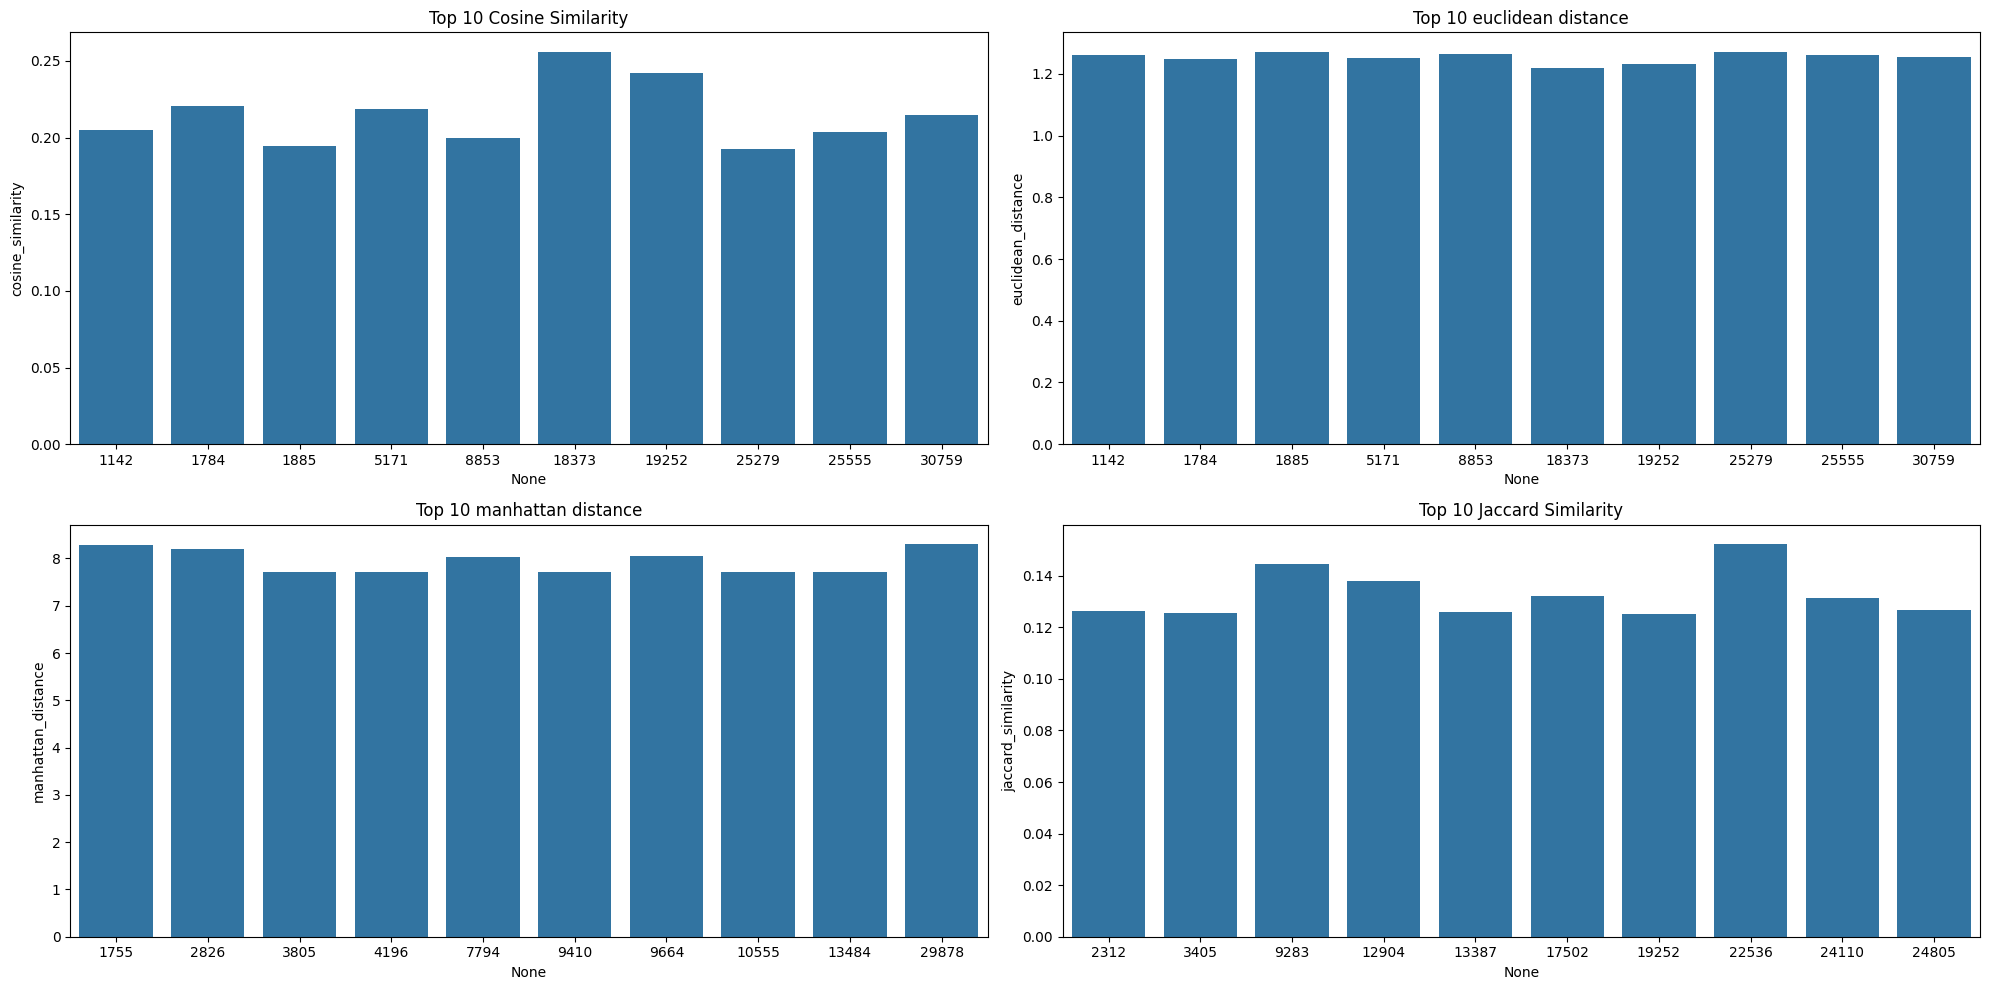

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.barplot(ax=axes[0, 0], x=top_cosine.index, y=top_cosine["cosine_similarity"])
axes[0, 0].set_title("Top 10 Cosine Similarity")

sns.barplot(ax=axes[0, 1], x=top_euclidean.index, y=top_euclidean["euclidean_distance"])
axes[0, 1].set_title("Top 10 euclidean distance")

sns.barplot(ax=axes[1, 0], x=top_manhattan.index, y=top_manhattan["manhattan_distance"])
axes[1, 0].set_title("Top 10 manhattan distance")

sns.barplot(ax=axes[1, 1], x=top_jaccard.index, y=top_jaccard["jaccard_similarity"])
axes[1, 1].set_title("Top 10 Jaccard Similarity")

plt.tight_layout()
plt.show()

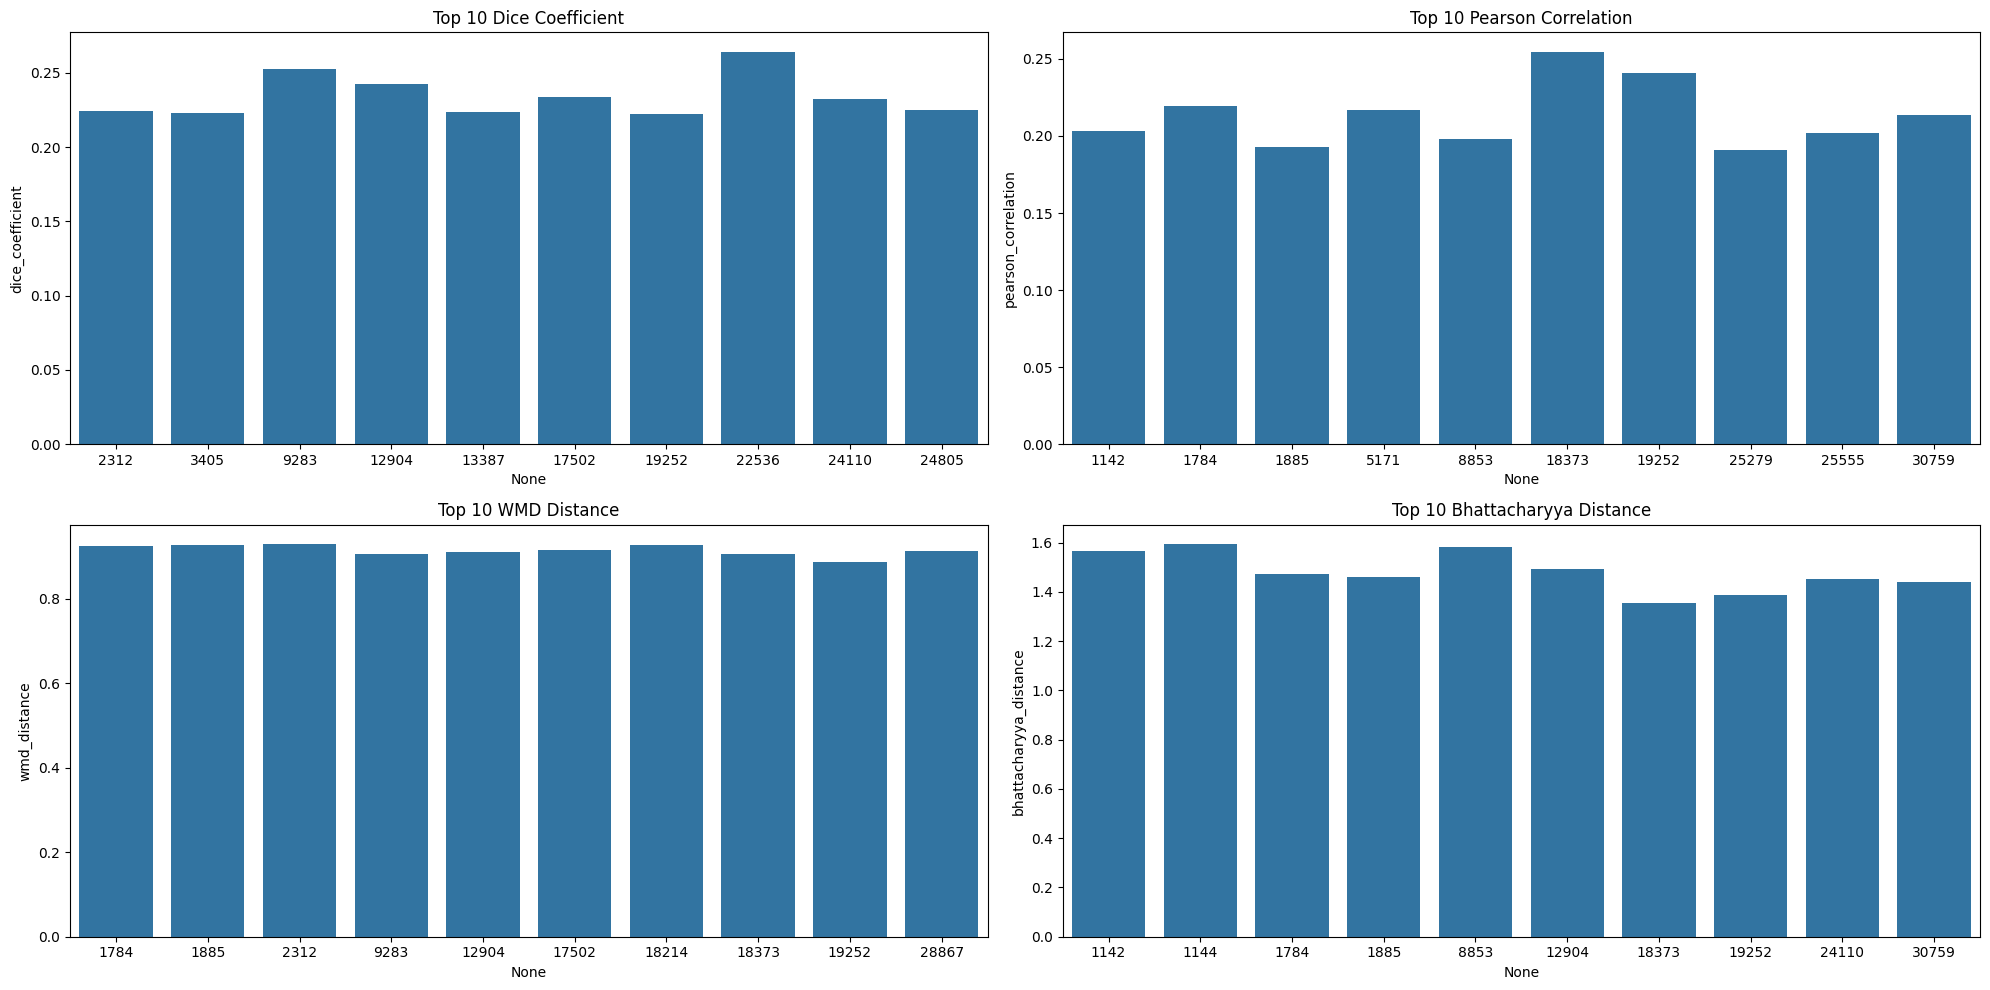

In [119]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.barplot(ax=axes[0, 0], x=top_dice.index, y=top_dice["dice_coefficient"])
axes[0, 0].set_title("Top 10 Dice Coefficient")

sns.barplot(ax=axes[0, 1], x=top_pearson.index, y=top_pearson["pearson_correlation"])
axes[0, 1].set_title("Top 10 Pearson Correlation")

sns.barplot(ax=axes[1, 0], x=top_wmd.index, y=top_wmd["wmd_distance"])
axes[1, 0].set_title("Top 10 WMD Distance")

sns.barplot(ax=axes[1, 1], x=top_bhattacharyya.index, y=top_bhattacharyya["bhattacharyya_distance"])
axes[1, 1].set_title("Top 10 Bhattacharyya Distance")

plt.tight_layout()
plt.show()

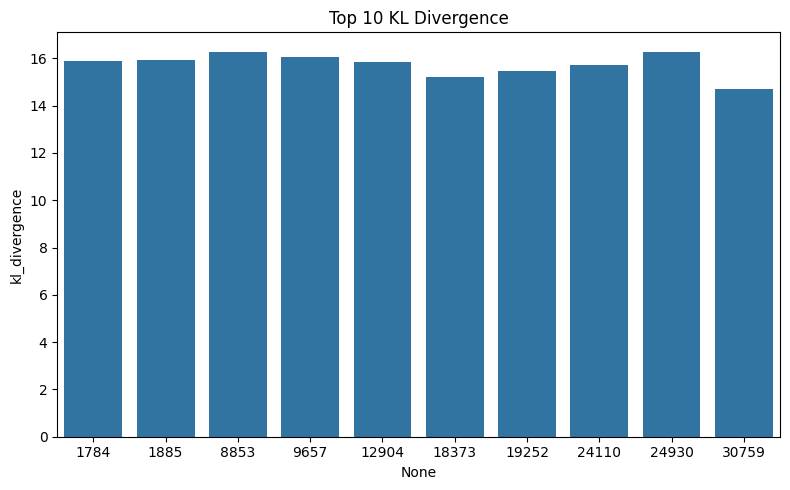

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.barplot(ax=ax, x=top_kl.index, y=top_kl["kl_divergence"])
ax.set_title("Top 10 KL Divergence")

plt.tight_layout()
plt.show()

perbandingan CountVectoraiser dan TF-IDF


# Contoh 2

In [121]:
input_text = "At the age of 28, I, John Smith, am an enthusiastic and highly skilled data analyst seeking to advance my career by applying for a position in the data field. With over five years of experience in data analysis and a proven track record of successfully implementing data-driven strategies, I have honed my expertise in various analytical tools and methodologies. I hold a Bachelor's degree in Computer Science from the University of California, Berkeley, and a Master's degree in Data Science from Stanford University. Throughout my career, I have demonstrated exceptional analytical capabilities, strong problem-solving skills, and a deep understanding of statistical models and machine learning algorithms. My passion for uncovering insights from complex datasets and my commitment to continuous learning make me a valuable candidate for any data-driven organization."

In [122]:
input_text = input_text.lower()

In [123]:
input_text = re.sub(r'[^\w\s]', '', input_text)

In [124]:
tokens = word_tokenize(input_text)

In [125]:
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]

In [126]:
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(word) for word in tokens]

In [127]:
input_text = ' '.join(tokens)

In [128]:
input_text

'age 28 john smith enthusiastic highly skilled data analyst seeking advance career applying position data field five year experience data analysis proven track record successfully implementing datadriven strategy honed expertise various analytical tool methodology hold bachelor degree computer science university california berkeley master degree data science stanford university throughout career demonstrated exceptional analytical capability strong problemsolving skill deep understanding statistical model machine learning algorithm passion uncovering insight complex datasets commitment continuous learning make valuable candidate datadriven organization'

In [129]:
corpus = dataset["deskripsi_keterampilan_final"].tolist() + [input_text]

In [130]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

In [131]:
cosine_similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])
dataset["cosine_similarity"] = cosine_similarities.flatten()

In [132]:
euclidean_dist = euclidean_distances(tfidf_matrix[-1], tfidf_matrix[:-1])
dataset["euclidean_distance"] = euclidean_dist.flatten()

In [133]:
manhattan_dist = manhattan_distances(tfidf_matrix[-1], tfidf_matrix[:-1])
dataset["manhattan_distance"] = manhattan_dist.flatten()

In [134]:
def jaccard_similarity(s1, s2):
    s1 = set(s1.split())
    s2 = set(s2.split())
    return len(s1 & s2) / len(s1 | s2)
dataset["jaccard_similarity"] = dataset["deskripsi_keterampilan_final"].apply(lambda x: jaccard_similarity(x, input_text))

In [135]:
def dice_coefficient(s1, s2):
    s1 = set(s1.split())
    s2 = set(s2.split())
    return 2 * len(s1 & s2) / (len(s1) + len(s2))
dataset["dice_coefficient"] = dataset["deskripsi_keterampilan_final"].apply(lambda x: dice_coefficient(x, input_text))

In [136]:
def pearson_corr(x, y):
    return pearsonr(x.toarray().flatten(), y.toarray().flatten())[0]
pearson_corrs = [pearson_corr(tfidf_matrix[i], tfidf_matrix[-1]) for i in range(len(corpus) - 1)]
dataset["pearson_correlation"] = pearson_corrs

In [137]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text
def wmd_distance(s1, s2):
    s1 = clean_text(s1)
    s2 = clean_text(s2)

    s1_words = s1.split()
    s2_words = s2.split()

    s1_words = [word for word in s1_words if word in model]
    s2_words = [word for word in s2_words if word in model]

    if not s1_words or not s2_words:
        return float('inf')

    return model.wmdistance(s1_words, s2_words)
dataset["wmd_distance"] = dataset["deskripsi_keterampilan_final"].apply(lambda x: wmd_distance(x, input_text))

In [138]:
def bhattacharyya_distance(p, q):
    return -np.log(np.sum(np.sqrt(p * q)))
def bhattacharyya_distance_from_vector(x, y):
    p = x / np.sum(x)
    q = y / np.sum(y)
    return bhattacharyya_distance(p, q)
bhattacharyya_distances = [bhattacharyya_distance_from_vector(tfidf_matrix[i].toarray().flatten(), tfidf_matrix[-1].toarray().flatten()) for i in range(len(corpus) - 1)]
dataset["bhattacharyya_distance"] = bhattacharyya_distances

<ipython-input-138-d747bff218ee>:2: RuntimeWarning: divide by zero encountered in log
  return -np.log(np.sum(np.sqrt(p * q)))


In [139]:
def kl_divergence_from_vector(p, q):
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return entropy(p, q)
kl_divergences = [kl_divergence_from_vector(tfidf_matrix[i].toarray().flatten(), tfidf_matrix[-1].toarray().flatten()) for i in range(len(corpus) - 1)]
dataset["kl_divergence"] = kl_divergences

### Hasil

In [140]:
top_similar = dataset.sort_values(by='cosine_similarity', ascending=False).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
18373    3757469023       16198010                   Sales   
19252    3757450438         871133  Information Technology   
1784     3693049684       18581793      Project Management   
5171     3693591031          45975                 Analyst   
30759    3757454354         871133  Information Technology   
1142     3693046569       10577525      Project Management   
25555    3756113091        6408728             Engineering   
8853     3697394881          26067             Engineering   
1885     3693050174         163414      Project Management   
25279    3757489682         624581  Information Technology   

                                             job title jenis_pekerjaan  \
18373  next generation data analyst site new york city       Full-time   
19252                                   data scientist       Full-time   
1784                                    senior manager       Full-time   
5171              senior assessment evaluation analyst       Full-time   
30759                           machine learn engineer       Full-time   
1142                             data scientist remote       Full-time   
25555                            director data science       Full-time   
8853          analytics data solution architect stream       Full-time   
1885                                   product manager       Full-time   
25279                              senior data analyst       Full-time   

        registration_type category sponsor                    city  \
18373  ComplexOnsiteApply    not sponsored                new york   
19252  ComplexOnsiteApply    not sponsored                new york   
1784   ComplexOnsiteApply        sponsored  san francisco bay area   
5171         OffsiteApply        sponsored               palo alto   
30759  ComplexOnsiteApply    not sponsored                new york   
1142   ComplexOnsiteApply    not sponsored                new york   
25555        OffsiteApply        sponsored                  queens   
8853         OffsiteApply    not sponsored              scottsdale   
1885         OffsiteApply    not sponsored                 No Info   
25279        OffsiteApply    not sponsored                   plano   

            state         county  \
18373    new york  united states   
19252    new york  united states   
1784   california  united states   
5171   california  united states   
30759    new york  united states   
1142     new york  united states   
25555    new york  united states   
8853      arizona  united states   
1885      No Info  united states   
25279       texas  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [141]:
top_similar['cosine_similarity']

18373    0.255812
19252    0.241991
1784     0.220682
5171     0.218449
30759    0.214619
1142     0.205005
25555    0.203654
8853     0.199543
1885     0.194436
25279    0.192532
Name: cosine_similarity, dtype: float64

In [142]:
top_similar = dataset.sort_values(by='euclidean_distance', ascending=True).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
18373    3757469023       16198010                   Sales   
19252    3757450438         871133  Information Technology   
1784     3693049684       18581793      Project Management   
5171     3693591031          45975                 Analyst   
30759    3757454354         871133  Information Technology   
1142     3693046569       10577525      Project Management   
25555    3756113091        6408728             Engineering   
8853     3697394881          26067             Engineering   
1885     3693050174         163414      Project Management   
25279    3757489682         624581  Information Technology   

                                             job title jenis_pekerjaan  \
18373  next generation data analyst site new york city       Full-time   
19252                                   data scientist       Full-time   
1784                                    senior manager       Full-time   
5171              senior assessment evaluation analyst       Full-time   
30759                           machine learn engineer       Full-time   
1142                             data scientist remote       Full-time   
25555                            director data science       Full-time   
8853          analytics data solution architect stream       Full-time   
1885                                   product manager       Full-time   
25279                              senior data analyst       Full-time   

        registration_type category sponsor                    city  \
18373  ComplexOnsiteApply    not sponsored                new york   
19252  ComplexOnsiteApply    not sponsored                new york   
1784   ComplexOnsiteApply        sponsored  san francisco bay area   
5171         OffsiteApply        sponsored               palo alto   
30759  ComplexOnsiteApply    not sponsored                new york   
1142   ComplexOnsiteApply    not sponsored                new york   
25555        OffsiteApply        sponsored                  queens   
8853         OffsiteApply    not sponsored              scottsdale   
1885         OffsiteApply    not sponsored                 No Info   
25279        OffsiteApply    not sponsored                   plano   

            state         county  \
18373    new york  united states   
19252    new york  united states   
1784   california  united states   
5171   california  united states   
30759    new york  united states   
1142     new york  united states   
25555    new york  united states   
8853      arizona  united states   
1885      No Info  united states   
25279       texas  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [143]:
top_similar['euclidean_distance']

18373    1.219991
19252    1.231267
1784     1.248453
5171     1.250241
30759    1.253301
1142     1.260948
25555    1.262019
8853     1.265272
1885     1.269302
25279    1.270802
Name: euclidean_distance, dtype: float64

In [144]:
top_similar = dataset.sort_values(by='manhattan_distance', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
10555,3699088610,4196994,Education,article teacher,Full-time,SimpleOnsiteApply,not sponsored,washington,district of columbia,united states,artist,0.000000,1.414214,7.705016,0.000000,0.000000,-0.000165,1.371905,inf,24.928609
13484,3694158424,96350264,Quality Assurance,linkedin test vacancy,Contract,OffsiteApply,not sponsored,kings park,new york,united states,testtesttesttesttesttesttesttesttesttesttesttesttesttest,0.000000,1.414214,7.705016,0.000000,0.000000,-0.000165,inf,inf,24.928609
9410,3699057694,82301960,Legal,paralegal,Full-time,SimpleOnsiteApply,not sponsored,downers grove,illinois,united states,paralegal,0.000000,1.414214,7.705016,0.000000,0.000000,-0.000165,1.348018,inf,24.928609
3805,3693070832,75156982,Human Resources,group facilitator,Other,SimpleOnsiteApply,not sponsored,denver,colorado,united states,facilitator,0.000000,1.414214,7.705016,0.000000,0.000000,-0.000165,1.357242,inf,24.928609
4196,3693075405,1512,Sales,inbound stock team member,Part-time,ComplexOnsiteApply,not sponsored,scotts valley,california,united states,name,0.000000,1.414214,7.705016,0.000000,0.000000,-0.000165,1.378572,inf,24.928609
7794,3694126099,1384029,Finance,loan officer,Full-time,SimpleOnsiteApply,not sponsored,No Info,california,united states,go getter,0.000000,1.414214,8.030879,0.000000,0.000000,-0.000218,1.338333,inf,24.306018
9664,3694142328,13186641,Management,new york 迪拜分公司总经理,Full-time,ComplexOnsiteApply,not sponsored,new york,new york,united states,负责 在纽约 在纽约,0.000000,1.414214,8.046657,0.000000,0.000000,-0.000221,inf,inf,24.292121
2826,3693058243,1068662,Legal,associate attorney,Full-time,SimpleOnsiteApply,not sponsored,troy,michigan,united states,year fault experience necessary,0.008899,1.407907,8.198111,0.028986,0.056338,0.008641,1.229115,3.204118,19.786906
1755,3693049516,56581630,Management,senior transportation planner,Full-time,OffsiteApply,not sponsored,seattle,washington,united states,new sidewalk program manager,0.000000,1.414214,8.284074,0.000000,0.000000,-0.000260,1.309096,inf,23.797363
29878,3756117095,756229,Accounting/Auditing,senior accountant,Full-time,OffsiteApply,not sponsored,roseville,california,united states,senior accountant year experience,0.010685,1.406638,8.295685,0.028986,0.056338,0.010412,1.244217,3.142246,19.188017


In [145]:
top_similar['manhattan_distance']

10555    7.705016
13484    7.705016
9410     7.705016
3805     7.705016
4196     7.705016
7794     8.030879
9664     8.046657
2826     8.198111
1755     8.284074
29878    8.295685
Name: manhattan_distance, dtype: float64

In [146]:
top_similar = dataset.sort_values(by='jaccard_similarity', ascending=False).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
22536,3755577654,2562128,Engineering,senior software scientist medical imaging,Full-time,ComplexOnsiteApply,not sponsored,buffalo grove,illinois,united states,qualification ph master degree computer science software engineering related field prefer exceptional candidate stem area highly encourage apply minimum year hand experience algorithm development primarily c ct medical imaging application deep understanding ct medical image modality proven expertise computer vision machine learning medical image processing strong software design unit test skill knowledge medical terminology biomedical engineering desirable strong publication intellectual property record relate ai medical imaging proficiency program c python additional relevant languages excellent debugging troubleshoot ability familiarity directx firmware game engine image reconstruction matrix inversion lut implementation gpu cpu multithreading experience nvidia object orient coding python familiarity software architectural design design pattern sdlc tcp ip xml schema simulation agile methodology,0.091258,1.348141,12.772271,0.152174,0.264151,0.090018,0.930919,1.744911,17.611063
9283,3699055896,51701268,Information Technology,tableau architect,Contract,ComplexOnsiteApply,sponsored,No Info,new jersey,united states,seek experienced senior business intelligence architect strong focus tableau expertise join dynamic team ideal candidate proven track record interpret functional need leading requirement gather session design complex business intelligence system provide valuable insight use tableau seasoned professional extensive experience data analysis dashboard design mentoring encourage apply responsibility interpret functional need translate effective business intelligence solution lead facilitate requirement gather session stakeholder document detailed requirement design architect complex business intelligence system align organizational goal develop impact ful tableau dashboard report use various data source aws sql etc utilize expertise data warehousing tool technique data stage etl tableau prep ensure data quality consistency demonstrate deep understanding data warehouse lifecycle data source etl multidimensional model data mart star schema report provide consulting leadership mentorship junior team member analyze data identify pattern trend insight drive business decision making requirement bachelor degree computer science information technology business related field minimum year overall professional experience building bi report solution extensive experience depth knowledge business intelligence tool architecture least year hand experience tableau design development strong expertise bi design complex system project proficiency design dashboard report use diverse data source include aws sql etc familiarity data warehouse tool technique data stage etl tableau prep thorough understanding data warehouse lifecycle data source etl multidimensional model report exceptional consulting leadership mentor ability,0.138009,1.313005,12.535152,0.144578,0.252632,0.136865,0.905640,1.610408,16.691035
12904,3701310859,490432,Engineering,financial planning consultant,Contract,ComplexOnsiteApply,not sponsored,wilmington,delaware,united states,fp consultant wilmington role job description seek highly skilled experienced financial planning analysis fp data architect expertise tool strong background banking financial domain key member team responsible design implementing maintain data architecture responsibility data architecture design collaborate cross functional team understand business requirement design robust data architecture cater financial planning analysis need organization data in

In [147]:
top_similar['jaccard_similarity']

22536    0.152174
9283     0.144578
12904    0.137931
17502    0.132184
24110    0.131313
24805    0.126761
2312     0.126506
13387    0.126087
3405     0.125581
19252    0.125000
Name: jaccard_similarity, dtype: float64

In [148]:
top_similar = dataset.sort_values(by='dice_coefficient', ascending=False).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
22536,3755577654,2562128,Engineering,senior software scientist medical imaging,Full-time,ComplexOnsiteApply,not sponsored,buffalo grove,illinois,united states,qualification ph master degree computer science software engineering related field prefer exceptional candidate stem area highly encourage apply minimum year hand experience algorithm development primarily c ct medical imaging application deep understanding ct medical image modality proven expertise computer vision machine learning medical image processing strong software design unit test skill knowledge medical terminology biomedical engineering desirable strong publication intellectual property record relate ai medical imaging proficiency program c python additional relevant languages excellent debugging troubleshoot ability familiarity directx firmware game engine image reconstruction matrix inversion lut implementation gpu cpu multithreading experience nvidia object orient coding python familiarity software architectural design design pattern sdlc tcp ip xml schema simulation agile methodology,0.091258,1.348141,12.772271,0.152174,0.264151,0.090018,0.930919,1.744911,17.611063
9283,3699055896,51701268,Information Technology,tableau architect,Contract,ComplexOnsiteApply,sponsored,No Info,new jersey,united states,seek experienced senior business intelligence architect strong focus tableau expertise join dynamic team ideal candidate proven track record interpret functional need leading requirement gather session design complex business intelligence system provide valuable insight use tableau seasoned professional extensive experience data analysis dashboard design mentoring encourage apply responsibility interpret functional need translate effective business intelligence solution lead facilitate requirement gather session stakeholder document detailed requirement design architect complex business intelligence system align organizational goal develop impact ful tableau dashboard report use various data source aws sql etc utilize expertise data warehousing tool technique data stage etl tableau prep ensure data quality consistency demonstrate deep understanding data warehouse lifecycle data source etl multidimensional model data mart star schema report provide consulting leadership mentorship junior team member analyze data identify pattern trend insight drive business decision making requirement bachelor degree computer science information technology business related field minimum year overall professional experience building bi report solution extensive experience depth knowledge business intelligence tool architecture least year hand experience tableau design development strong expertise bi design complex system project proficiency design dashboard report use diverse data source include aws sql etc familiarity data warehouse tool technique data stage etl tableau prep thorough understanding data warehouse lifecycle data source etl multidimensional model report exceptional consulting leadership mentor ability,0.138009,1.313005,12.535152,0.144578,0.252632,0.136865,0.905640,1.610408,16.691035
12904,3701310859,490432,Engineering,financial planning consultant,Contract,ComplexOnsiteApply,not sponsored,wilmington,delaware,united states,fp consultant wilmington role job description seek highly skilled experienced financial planning analysis fp data architect expertise tool strong background banking financial domain key member team responsible design implementing maintain data architecture responsibility data architecture design collaborate cross functional team understand business requirement design robust data architecture cater financial planning analysis need organization data in

In [149]:
top_similar['dice_coefficient']

22536    0.264151
9283     0.252632
12904    0.242424
17502    0.233503
24110    0.232143
24805    0.225000
2312     0.224599
13387    0.223938
3405     0.223140
19252    0.222222
Name: dice_coefficient, dtype: float64

In [150]:
top_similar = dataset.sort_values(by='pearson_correlation', ascending=False).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
18373    3757469023       16198010                   Sales   
19252    3757450438         871133  Information Technology   
1784     3693049684       18581793      Project Management   
5171     3693591031          45975                 Analyst   
30759    3757454354         871133  Information Technology   
1142     3693046569       10577525      Project Management   
25555    3756113091        6408728             Engineering   
8853     3697394881          26067             Engineering   
1885     3693050174         163414      Project Management   
25279    3757489682         624581  Information Technology   

                                             job title jenis_pekerjaan  \
18373  next generation data analyst site new york city       Full-time   
19252                                   data scientist       Full-time   
1784                                    senior manager       Full-time   
5171              senior assessment evaluation analyst       Full-time   
30759                           machine learn engineer       Full-time   
1142                             data scientist remote       Full-time   
25555                            director data science       Full-time   
8853          analytics data solution architect stream       Full-time   
1885                                   product manager       Full-time   
25279                              senior data analyst       Full-time   

        registration_type category sponsor                    city  \
18373  ComplexOnsiteApply    not sponsored                new york   
19252  ComplexOnsiteApply    not sponsored                new york   
1784   ComplexOnsiteApply        sponsored  san francisco bay area   
5171         OffsiteApply        sponsored               palo alto   
30759  ComplexOnsiteApply    not sponsored                new york   
1142   ComplexOnsiteApply    not sponsored                new york   
25555        OffsiteApply        sponsored                  queens   
8853         OffsiteApply    not sponsored              scottsdale   
1885         OffsiteApply    not sponsored                 No Info   
25279        OffsiteApply    not sponsored                   plano   

            state         county  \
18373    new york  united states   
19252    new york  united states   
1784   california  united states   
5171   california  united states   
30759    new york  united states   
1142     new york  united states   
25555    new york  united states   
8853      arizona  united states   
1885      No Info  united states   
25279       texas  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [151]:
top_similar['pearson_correlation']

18373    0.254528
19252    0.240760
1784     0.219332
5171     0.216751
30759    0.213606
1142     0.203496
25555    0.202149
8853     0.197928
1885     0.192968
25279    0.190684
Name: pearson_correlation, dtype: float64

In [152]:
filtered_dataset = dataset[dataset["wmd_distance"] != float('inf')]
top_similar = filtered_dataset.sort_values(by='wmd_distance', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
19252,3757450438,871133,Information Technology,data scientist,Full-time,ComplexOnsiteApply,not sponsored,new york,new york,united states,henderson harbor group premier executive search consult firm deep experience technology finance accounting tax search division recruit highly skilled professional direct hire basis service client primarily tri state area well nationally aafa npa network data scientist forefront data drive decision make process work closely cross functional team extract valuable insight data build predictive model provide actionable recommendation drive business forward key responsibilities collect pre process data various source ensure data quality accuracy explore analyze visualize data identify trend pattern insight develop machine learning model algorithm predictive prescriptive analytics collaborate domain expert stakeholder define business problem objective design experiment conduct statistical analysis test hypothesis validate model evaluate select appropriate tool framework library data analysis model create data drive report dashboard communicate finding recommendation stay date latest data science technique technology participate development data science strategy road maps contribute data related project mentor junior data scientist provide technical guidance maintain strong focus data privacy ethic compliance qualifications bachelor master degree quantitative field computer science statistic data science proven experience data scientist similar role proficiency data analysis visualization tool python r sql strong knowledge machine learning statistic data mining experience data manipulation modeling library e g panda sci kit learn tensor flow strong problem solving analytical skill excellent communication presentation skill ability work effectively collaborative team environment knowledge big data technology distribute computing plus industry specific experience may require base role e g healthcare finance e commerce etc,0.241991,1.231267,13.744372,0.125000,0.222222,0.240760,0.885772,1.385320,15.449700
18373,3757469023,16198010,Sales,next generation data analyst site new york city,Full-time,ComplexOnsiteApply,not sponsored,new york,new york,united states,seek talented forward think next generation data analyst join team next generation data analyst play crucial role shape future data analysis within organization primary responsibility collaborate closely leadership understand business need identify data driven insight stay abreast industry trend emerge technology best practice data analysis position require deep understanding data analysis excellent problem solve skill hand experience key responsibility collaboration leadership work closely leadership understand business objective provide data driven insight inform decision making process present analysis finding recommendation leadership clear concise manner facilitate data drive discussion strategic planning assist ceo identify key performance indicator kpis metric measure success business strategy contribute develop data driven strategy initiative enhance business performance competitiveness data visualization create visually appeal easy understand dashboard chart report communicate complex data insight stakeholder use data visualization tool present finding compelling impact ful manner clean pre process analyze large datasets extract valuable pattern trend insight build deploy machine learning model various application predictive analytics recommendation system anomaly detection utilize statistical method tool validate model ensure accuracy reliability data quality integrity ensure data accuracy completeness consistency implement quality check vali

In [153]:
top_similar['wmd_distance']

19252    0.885772
18373    0.904577
9283     0.905640
12904    0.909893
28867    0.913847
17502    0.915533
1784     0.924095
1885     0.926653
18214    0.927891
2312     0.928276
Name: wmd_distance, dtype: float64

In [154]:
top_similar = dataset.sort_values(by='bhattacharyya_distance', ascending=True).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
18373    3757469023       16198010                   Sales   
19252    3757450438         871133  Information Technology   
30759    3757454354         871133  Information Technology   
24110    3757461432         490432             Engineering   
1885     3693050174         163414      Project Management   
1784     3693049684       18581793      Project Management   
12904    3701310859         490432             Engineering   
1142     3693046569       10577525      Project Management   
8853     3697394881          26067             Engineering   
1144     3693046572        2944478                 Finance   

                                             job title jenis_pekerjaan  \
18373  next generation data analyst site new york city       Full-time   
19252                                   data scientist       Full-time   
30759                           machine learn engineer       Full-time   
24110                                   data scientist       Full-time   
1885                                   product manager       Full-time   
1784                                    senior manager       Full-time   
12904                    financial planning consultant        Contract   
1142                             data scientist remote       Full-time   
8853          analytics data solution architect stream       Full-time   
1144                                         economist       Full-time   

        registration_type category sponsor                    city  \
18373  ComplexOnsiteApply    not sponsored                new york   
19252  ComplexOnsiteApply    not sponsored                new york   
30759  ComplexOnsiteApply    not sponsored                new york   
24110  ComplexOnsiteApply    not sponsored                new york   
1885         OffsiteApply    not sponsored                 No Info   
1784   ComplexOnsiteApply        sponsored  san francisco bay area   
12904  ComplexOnsiteApply    not sponsored              wilmington   
1142   ComplexOnsiteApply    not sponsored                new york   
8853         OffsiteApply    not sponsored              scottsdale   
1144   ComplexOnsiteApply    not sponsored                 No Info   

            state         county  \
18373    new york  united states   
19252    new york  united states   
30759    new york  united states   
24110    new york  united states   
1885      No Info  united states   
1784   california  united states   
12904    delaware  united states   
1142     new york  united states   
8853      arizona  united states   
1144      No Info  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [155]:
top_similar['bhattacharyya_distance']

18373    1.352841
19252    1.385320
30759    1.440094
24110    1.453314
1885     1.461972
1784     1.473576
12904    1.490943
1142     1.565917
8853     1.581970
1144     1.592154
Name: bhattacharyya_distance, dtype: float64

In [156]:
filtered_dataset = dataset[dataset["kl_divergence"] != float('inf')]
top_similar = filtered_dataset.sort_values(by='kl_divergence', ascending=True).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
30759    3757454354         871133  Information Technology   
18373    3757469023       16198010                   Sales   
19252    3757450438         871133  Information Technology   
24110    3757461432         490432             Engineering   
12904    3701310859         490432             Engineering   
1784     3693049684       18581793      Project Management   
1885     3693050174         163414      Project Management   
9657     3694136835           1353  Information Technology   
8853     3697394881          26067             Engineering   
24930    3757495146        1769216             Engineering   

                                             job title jenis_pekerjaan  \
30759                           machine learn engineer       Full-time   
18373  next generation data analyst site new york city       Full-time   
19252                                   data scientist       Full-time   
24110                                   data scientist       Full-time   
12904                    financial planning consultant        Contract   
1784                                    senior manager       Full-time   
1885                                   product manager       Full-time   
9657                             game business analyst       Full-time   
8853          analytics data solution architect stream       Full-time   
24930             data architect scientist intravenous       Full-time   

        registration_type category sponsor                    city  \
30759  ComplexOnsiteApply    not sponsored                new york   
18373  ComplexOnsiteApply    not sponsored                new york   
19252  ComplexOnsiteApply    not sponsored                new york   
24110  ComplexOnsiteApply    not sponsored                new york   
12904  ComplexOnsiteApply    not sponsored              wilmington   
1784   ComplexOnsiteApply        sponsored  san francisco bay area   
1885         OffsiteApply    not sponsored                 No Info   
9657   ComplexOnsiteApply    not sponsored                bellevue   
8853         OffsiteApply    not sponsored              scottsdale   
24930  ComplexOnsiteApply    not sponsored                 belcamp   

            state         county  \
30759    new york  united states   
18373    new york  united states   
19252    new york  united states   
24110    new york  united states   
12904    delaware  united states   
1784   california  united states   
1885      No Info  united states   
9657   washington  united states   
8853      arizona  united states   
24930    maryland  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [157]:
top_similar['kl_divergence']

30759    14.701487
18373    15.194329
19252    15.449700
24110    15.738933
12904    15.843173
1784     15.879531
1885     15.941156
9657     16.080289
8853     16.284619
24930    16.288479
Name: kl_divergence, dtype: float64

### Visualisasi

In [158]:
top_cosine = dataset.sort_values(by='cosine_similarity', ascending=False).head(10)
top_euclidean = dataset.sort_values(by='euclidean_distance', ascending=True).head(10)
top_manhattan = dataset.sort_values(by='manhattan_distance', ascending=True).head(10)
top_jaccard = dataset.sort_values(by='jaccard_similarity', ascending=False).head(10)
top_dice = dataset.sort_values(by='dice_coefficient', ascending=False).head(10)
top_pearson = dataset.sort_values(by='pearson_correlation', ascending=False).head(10)
filtered_dataset_wmd = dataset[dataset["wmd_distance"] != float('inf')]
top_wmd = filtered_dataset_wmd.sort_values(by='wmd_distance', ascending=True).head(10)
top_bhattacharyya = dataset.sort_values(by='bhattacharyya_distance', ascending=True).head(10)
filtered_dataset_kl = dataset[dataset["kl_divergence"] != float('inf')]
top_kl = filtered_dataset_kl.sort_values(by='kl_divergence', ascending=True).head(10)

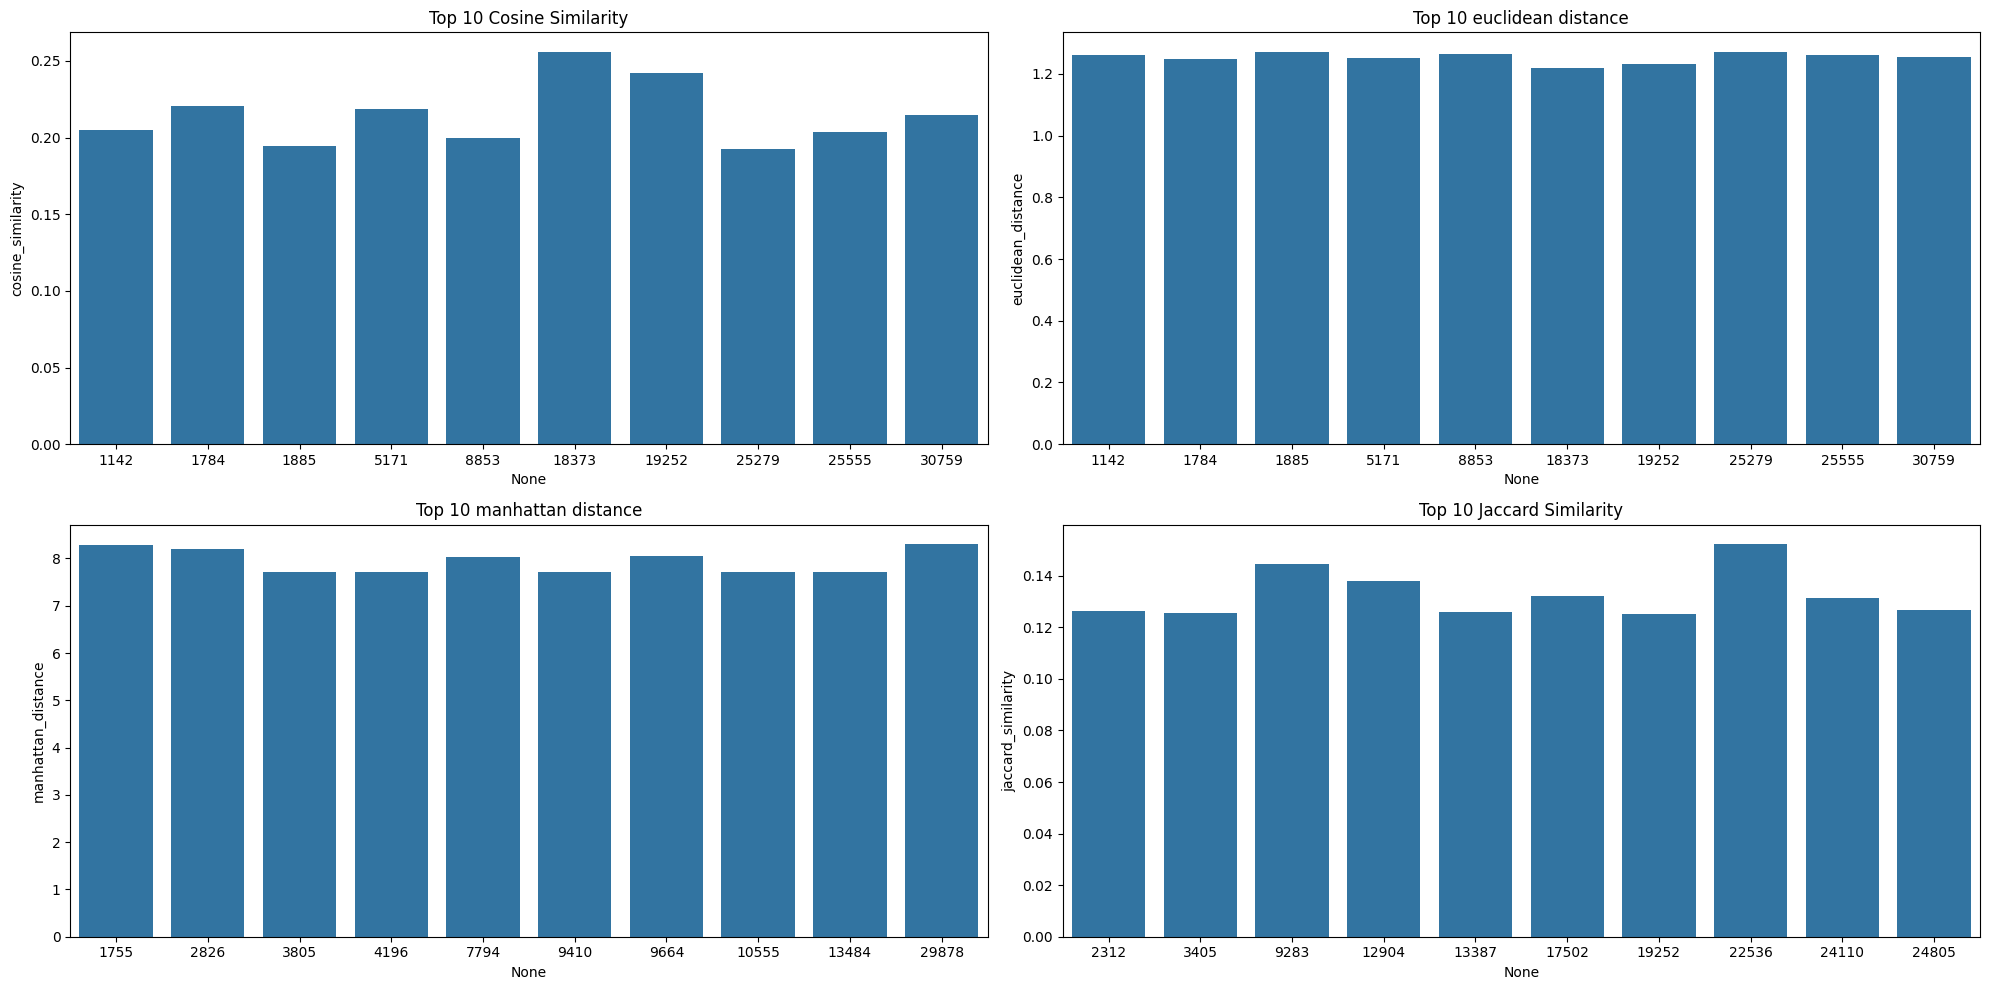

In [159]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.barplot(ax=axes[0, 0], x=top_cosine.index, y=top_cosine["cosine_similarity"])
axes[0, 0].set_title("Top 10 Cosine Similarity")

sns.barplot(ax=axes[0, 1], x=top_euclidean.index, y=top_euclidean["euclidean_distance"])
axes[0, 1].set_title("Top 10 euclidean distance")

sns.barplot(ax=axes[1, 0], x=top_manhattan.index, y=top_manhattan["manhattan_distance"])
axes[1, 0].set_title("Top 10 manhattan distance")

sns.barplot(ax=axes[1, 1], x=top_jaccard.index, y=top_jaccard["jaccard_similarity"])
axes[1, 1].set_title("Top 10 Jaccard Similarity")

plt.tight_layout()
plt.show()

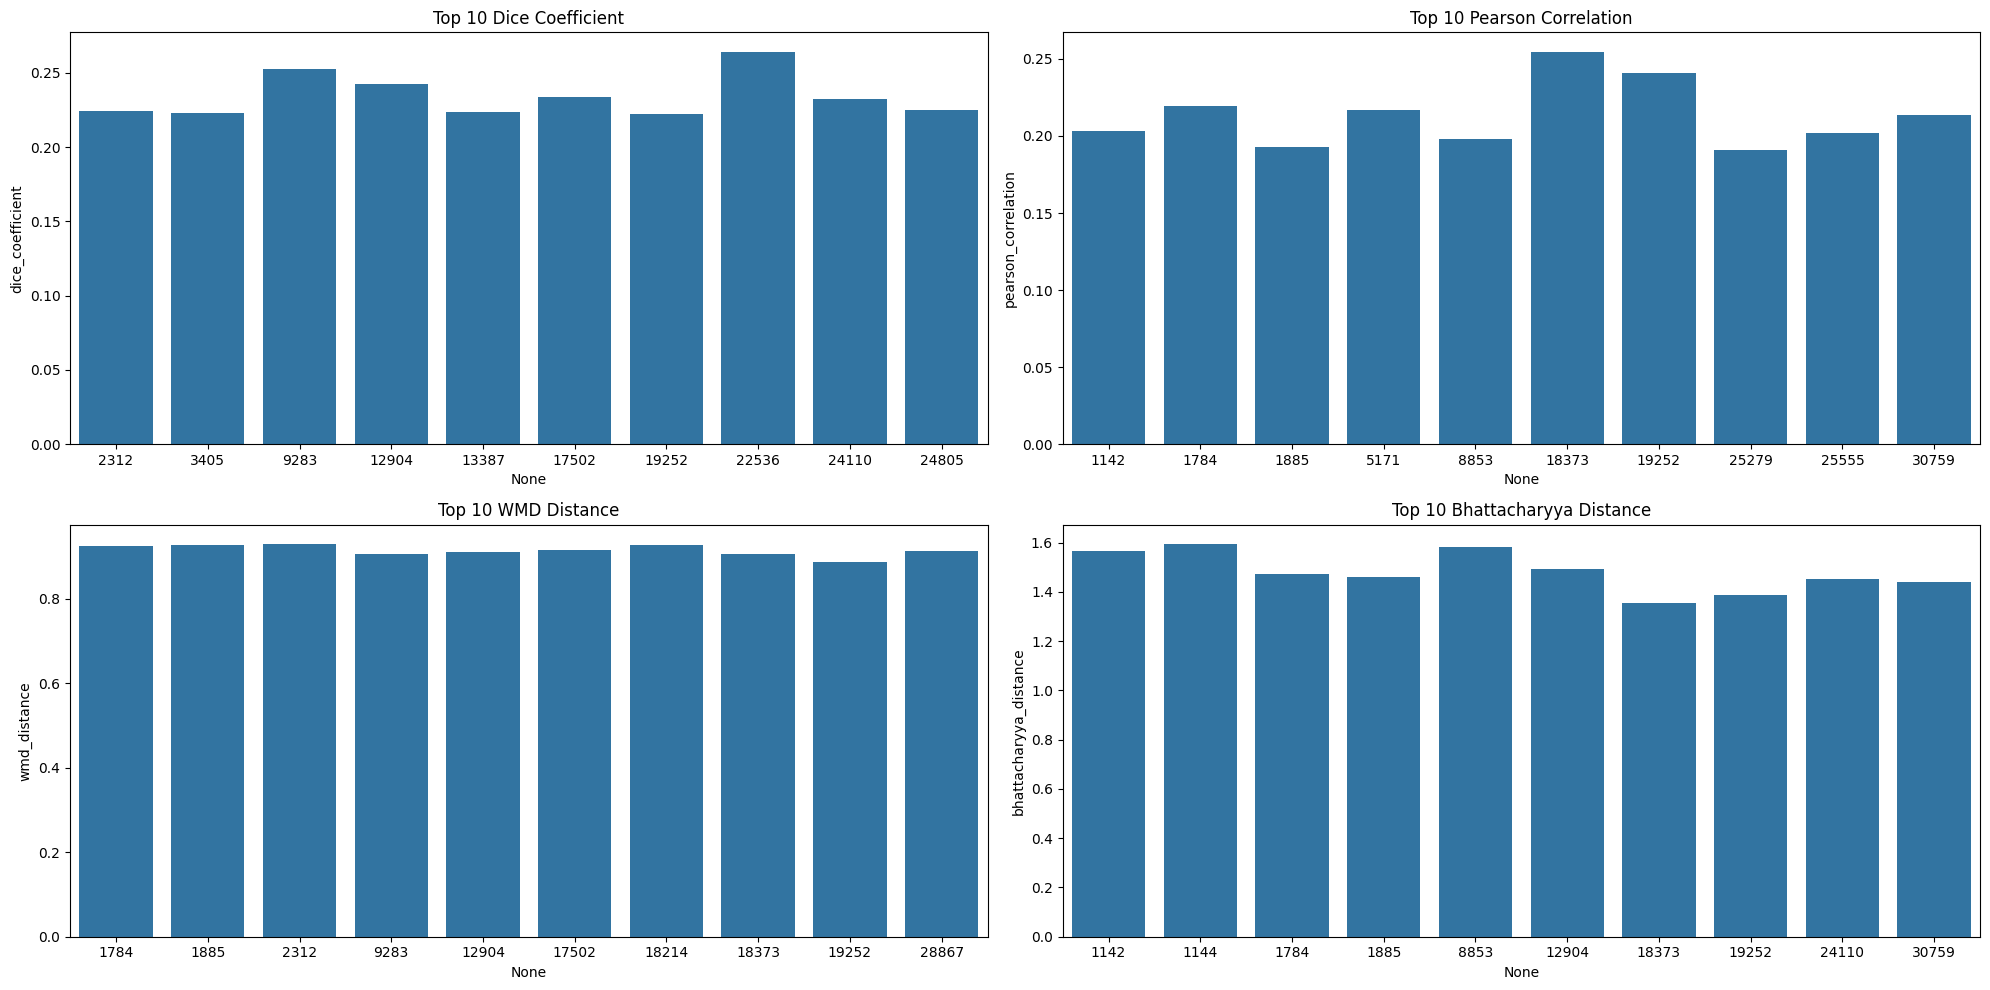

In [160]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.barplot(ax=axes[0, 0], x=top_dice.index, y=top_dice["dice_coefficient"])
axes[0, 0].set_title("Top 10 Dice Coefficient")

sns.barplot(ax=axes[0, 1], x=top_pearson.index, y=top_pearson["pearson_correlation"])
axes[0, 1].set_title("Top 10 Pearson Correlation")

sns.barplot(ax=axes[1, 0], x=top_wmd.index, y=top_wmd["wmd_distance"])
axes[1, 0].set_title("Top 10 WMD Distance")

sns.barplot(ax=axes[1, 1], x=top_bhattacharyya.index, y=top_bhattacharyya["bhattacharyya_distance"])
axes[1, 1].set_title("Top 10 Bhattacharyya Distance")

plt.tight_layout()
plt.show()

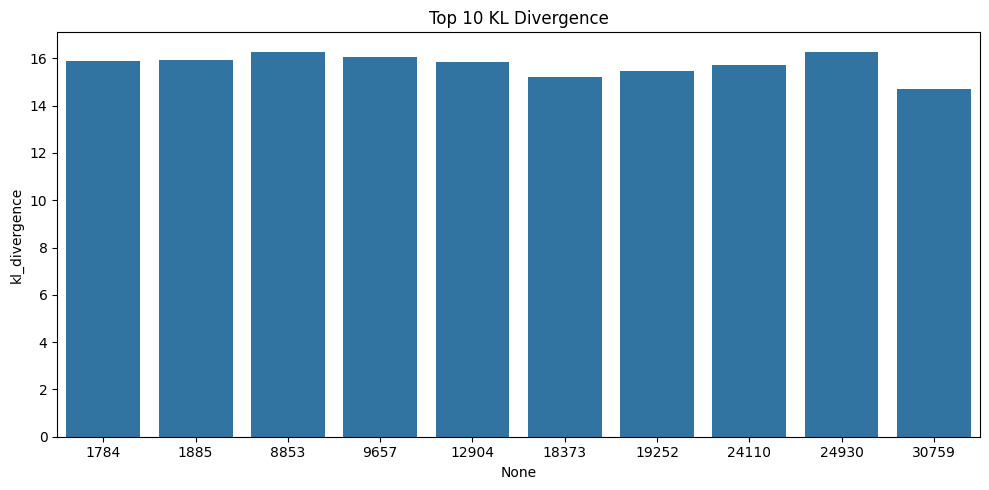

In [161]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.barplot(ax=ax, x=top_kl.index, y=top_kl["kl_divergence"])
ax.set_title("Top 10 KL Divergence")

plt.tight_layout()
plt.show()

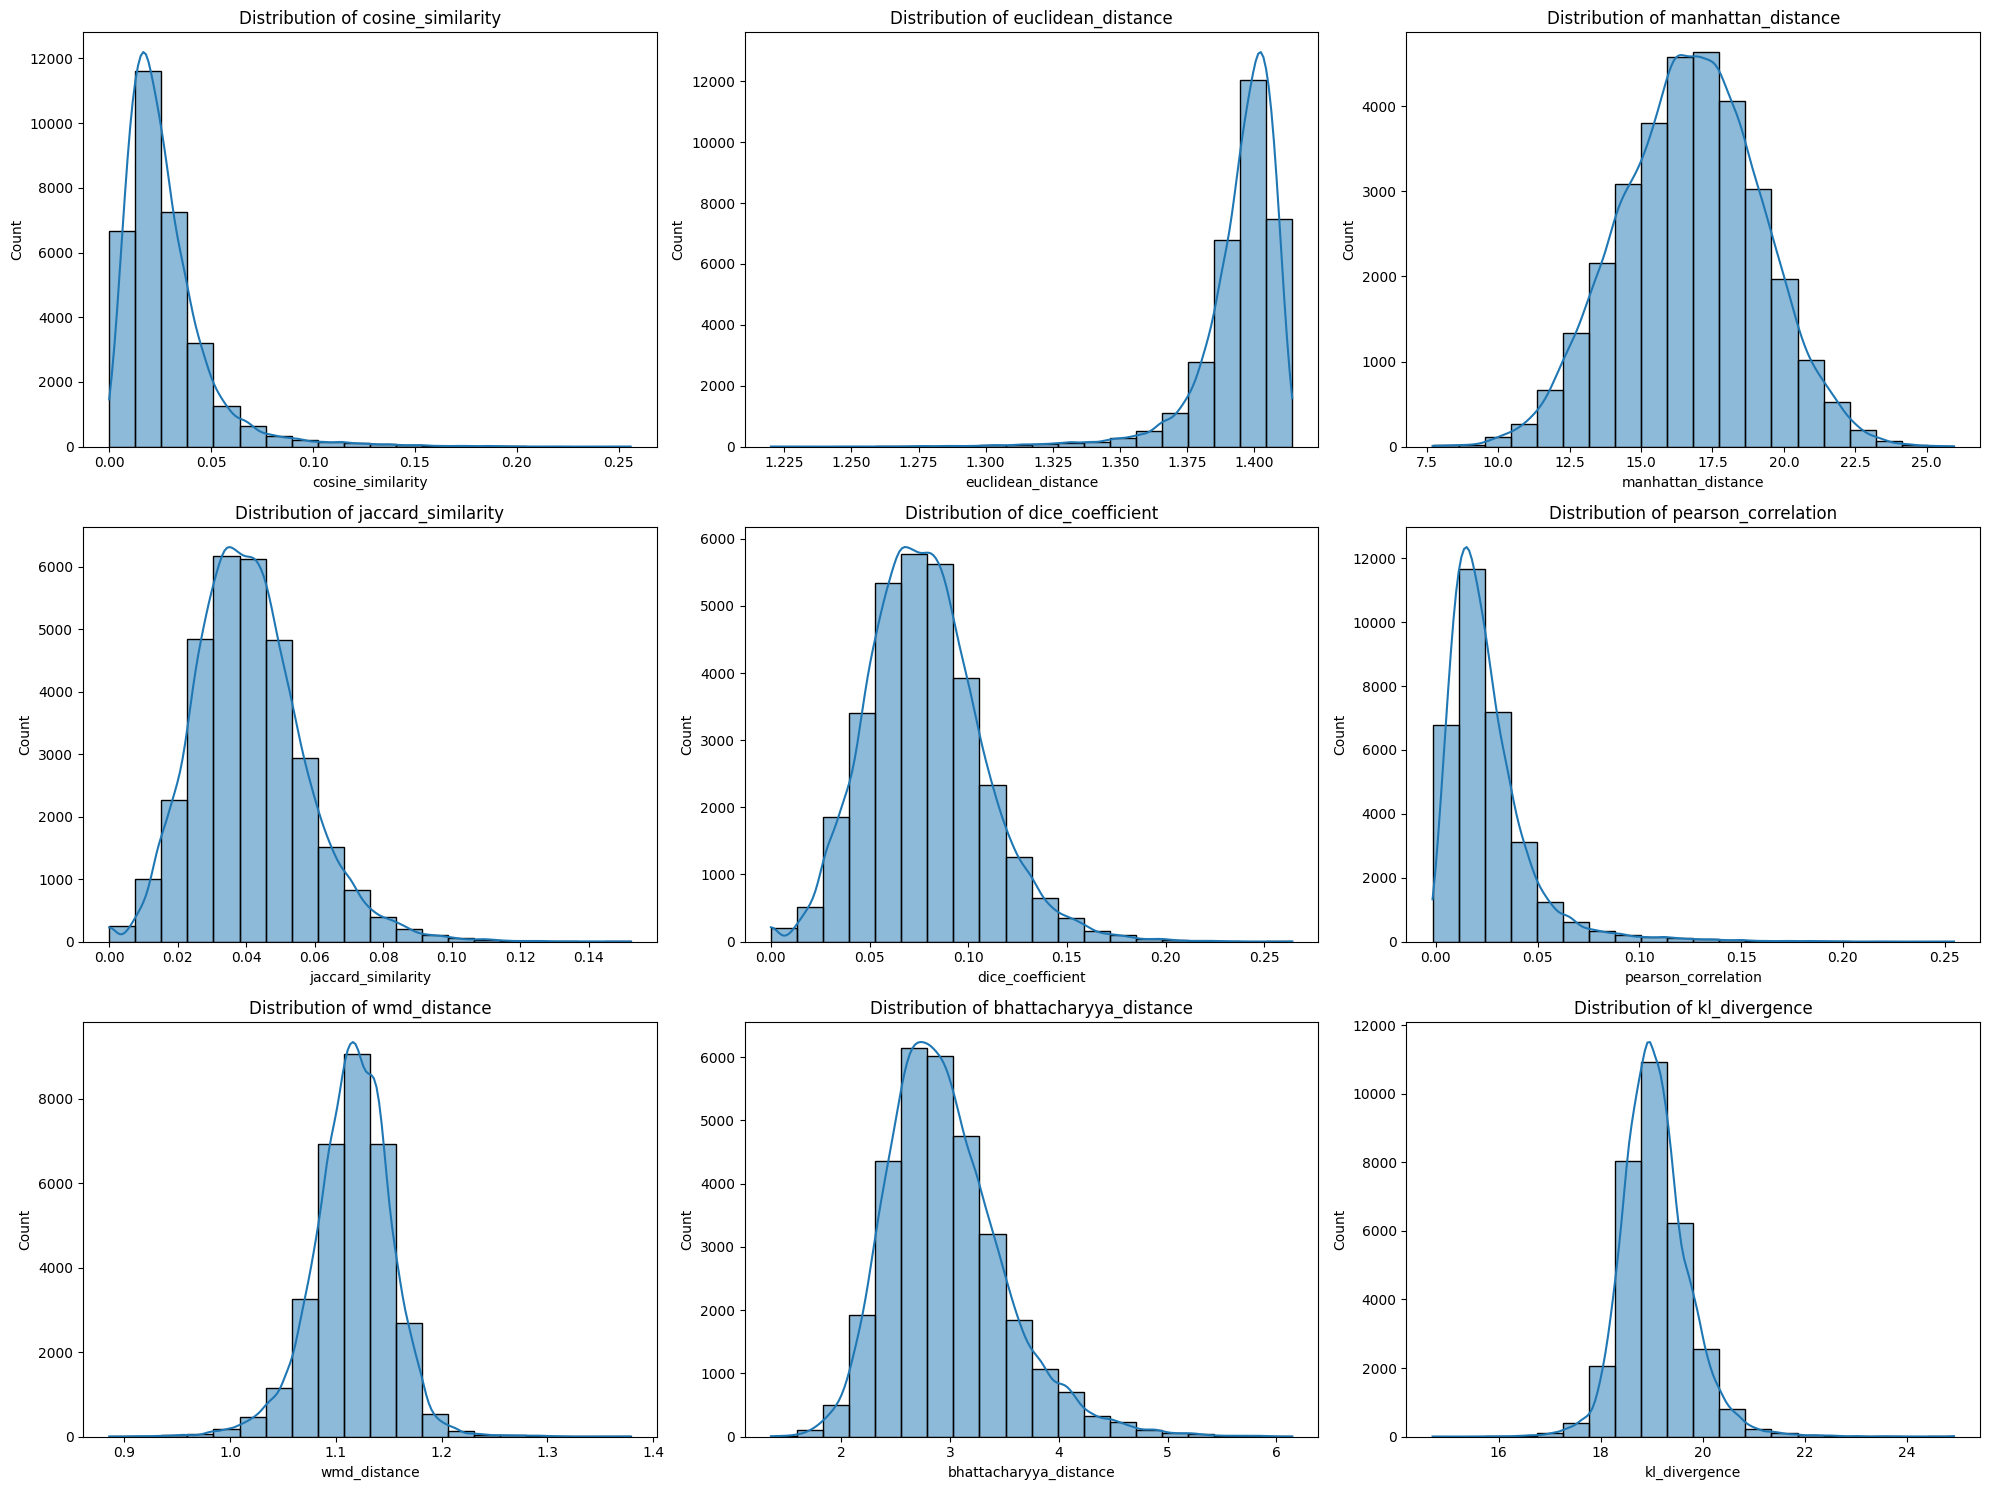

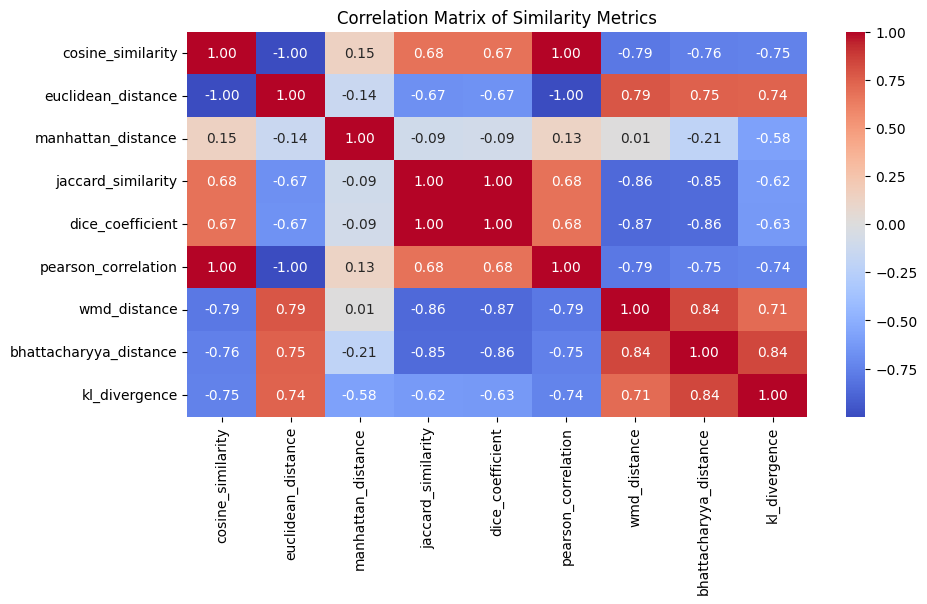

In [162]:
metrics = ['cosine_similarity', 'euclidean_distance', 'manhattan_distance', 'jaccard_similarity',
           'dice_coefficient', 'pearson_correlation', 'wmd_distance', 'bhattacharyya_distance',
           'kl_divergence']

plt.figure(figsize=(20, 15))
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.histplot(dataset[metric], bins=20, kde=True)
    plt.title(f'Distribution of {metric}')
plt.tight_layout()
plt.show()

correlation_matrix = dataset[metrics].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Similarity Metrics')
plt.show()